In [1]:
# Load the dataset
%matplotlib inline
import matplotlib.pyplot as pyPlot
import cPickle, gzip, numpy
import numpy as np
import matplotlib.pyplot as plt

f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()

train_x = 1*(train_set[0]>0.5)
test_x = 1*(test_set[0]>0.5)
valid_x = 1*(valid_set[0]>0.5)

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [39]:
#Training a nearest neighbour classifier
from sklearn.neighbors import NearestNeighbors

#model = NearestNeighbors(n_neighbors = 1,n_jobs = 7,leaf_size = 90,metric = 'hamming')
#%time model.fit(train_x)

In [40]:
#Testing the classifier
from scipy.stats import mode
from sklearn import metrics as evalMetrics

#%time testNearestPoints = model.kneighbors(test_x)
#testPred = train_set[1][testNearestPoints[1]]
#testPred = [mode(i)[0][0] for i in testPred]

#print evalMetrics.classification_report(test_set[1],testPred)
#print evalMetrics.confusion_matrix(test_set[1],testPred)
#print evalMetrics.accuracy_score(test_set[1],testPred)

In [5]:
#Randomly picking prototypes.
def randomPrototypePerformance(n,repeats=10):
    PRF = []
    Accuracy = []
    microFscore = []
    
    for i in range(repeats):
        randomIndices = np.random.randint(0,len(train_set[1]),n)
        trainRandom_x = train_x[randomIndices,:]
        trainRandom_y = train_set[1][randomIndices]

        modelRandomPrototypes = NearestNeighbors(n_neighbors = 1,n_jobs = 7,leaf_size = 90)
        modelRandomPrototypes.fit(trainRandom_x)

        testNearestPoints = modelRandomPrototypes.kneighbors(test_x)
        testPred = trainRandom_y[testNearestPoints[1]]
        testPred = [mode(i)[0][0] for i in testPred]

        PRF.append(evalMetrics.classification.precision_recall_fscore_support(test_set[1],testPred))
        Accuracy.append(evalMetrics.accuracy_score(test_set[1],testPred))
        microFscore.append(evalMetrics.f1_score(test_set[1],testPred,average = "macro"))
    
    Accuracy = np.array(Accuracy)
    
    Mean_accuracy = np.mean(Accuracy)
    Std_accuracy = np.std(Accuracy)
    
    Mean_microf = np.mean(microFscore)
    Std_microf = np.std(microFscore)
    
    P,R,F,S = zip(*PRF)

    F = np.matrix(F)
    Fstd = np.std(F,axis=0)     
    Fmean = np.mean(F,axis=0)
    
    return (Mean_accuracy,Std_accuracy,Mean_microf,Std_microf)

In [41]:
from collections import defaultdict
from tempfile import mkdtemp
import os.path as path
import heapq
import math

class heapPoint:
    
    def __init__(self,x,y):
        self.value = x
        self.index = y
    
    def __cmp__(self,obj):
        
        if self.value>obj.value:
            return -1
        else:
            return 1
            
class memmappedDistanceMatrix:
    
    def __init__(self,Data,Labels,memMap = False):
        
        self.noItems = Data.shape[0]
        
        #Create hashmap for original indices to compound (label,subIndex) indices
        self.indexLookupTable = dict()
        offset = defaultdict(int)
        
        #Partition data by labels
        self.labelSetIndices = defaultdict(list)
        
        for index,label in enumerate(Labels):
            self.indexLookupTable[index] = (label,offset[label]) 
            offset[label] += 1
            self.labelSetIndices[label].append(index)
        
        #Create the memory mapped distance matrices
        self.distanceMatrices = dict()

        for i in self.labelSetIndices.keys():
            filename = 'Label_'+str(i)+'.dat'
            print "Label " + str(i) + " in progress."
            
            hammingMat = np.dot(train_x[self.labelSetIndices[i],:],np.transpose(1-train_x[self.labelSetIndices[i],:])) + np.dot(1-train_x[self.labelSetIndices[i],:],np.transpose(train_x[self.labelSetIndices[i],:]))
            
            if memMap:
                memMat = np.memmap(filename, dtype='int16', mode='w+', shape=hammingMat.shape)
                memMat[:] = hammingMat[:]
                memMat.flush()
                del memMat
                del hammingMat
                self.distanceMatrices[i] = np.memmap(filename, dtype='int16', mode='w+', shape=hammingMat.shape)
            
            else:
                self.distanceMatrices[i] = hammingMat

        print "Done"
    
    def __getitem__(self,index):
        
        labelIndex,offset = self.indexLookupTable[index]
        
        #distanceVector = np.array([float("inf")]*self.noItems)
        #distanceVector[self.labelSetIndices[labelIndex]] = self.distanceMatrices[labelIndex][offset,:]
        
        return (self.distanceMatrices[labelIndex][offset,:])
    
    def getLabelOffsets(self,indices):
        
        coordinates = []
        
        for index in indices:
            coordinates.append(self.indexLookupTable[index][1])
        
        return np.array(coordinates)

distMat = memmappedDistanceMatrix(train_x,train_set[1])

Label 0 in progress.
Label 1 in progress.
Label 2 in progress.
Label 3 in progress.
Label 4 in progress.
Label 5 in progress.
Label 6 in progress.
Label 7 in progress.
Label 8 in progress.
Label 9 in progress.
Done


In [131]:
import heapq
from collections import namedtuple
import copy
import unittest
        
def fprime_manual(f,x,s,args = ()):
    """
    Manual calculation of marginal gain. If there is a optimal custom implementation
    this should be overidden by supplying the fprime argument. Similar in spirit to 
    numerical gradient calculation.
    
    Parameters:
    __________
    f: callable f(x,s,*args); the objective function
    x: element of input set to calculate marginal gain for
    args: tuple (optinal); additional arguments to be supplied to f
    
    Returns:
    _______
    Marginal gain for element x, set s for function f
    """
    if x in s:
        return 0
    else:
        s_new = copy.copy(s)
        s_new.append(x)
        return f(s_new,*args) - f(s,*args)

def fmax_submodular(f,s,fprime = None,sopt = None,k=float("Inf"),verbose = False,args=()):
    
    """
    Maximize a submodular function using the greedy method.
    
    Parameters:
    __________
    s: set of elements, search is performed over the powerset P(s).
    f: callable f(x,*args)
    fprime: callable fprime(x,s);If not supplied, defaults to manual cauculation
    args: tuple (optional) additional arguments to be passed to f
    k: Cardinatlity constraint |S|<k is enforced

    Returns:
    _______
    sopt: Optimal set for f
    fopt: Value of the function at the optimal point
    """

    if fprime == None:
        fprime = lambda x,s: fprime_manual(f,x,s,args)
    
    if sopt == None:
        sopt = []

    fopt = 0

    #Populate the heap
    heap_fprimes = [(-fprime(x,sopt),x) for x in s]
    heapq.heapify(heap_fprimes)
    
    while len(sopt)<k:

        x = heapq.heappop(heap_fprimes)
        x = (-fprime(x[1],sopt),x[1])

        while len(heap_fprimes)>0 and x[0]>heap_fprimes[0][0]:
            heapq.heappush(heap_fprimes,x)
            x = heapq.heappop(heap_fprimes)
            x = (-fprime(x[1],sopt),x[1])

        if x[0]>=0:
            break
        else:
            sopt.append(x[1])
            fopt += -x[0]
        if verbose:
            print str(100*len(sopt)/k) + "% done; Value of objective: "+str(fopt)
            
    solution = namedtuple("solution",["sopt","fopt"])

    return solution(sopt,fopt)

def set_cover(s):
	if len(s)==0:
		return 0
	else:
		return len(reduce(lambda x,y:x|y,s))+1

soln = fmax_submodular(set_cover,[{1,2},{1,3,4},{1,2,4,5,6},{7,8}])
print soln.sopt

[set([1, 2, 4, 5, 6]), set([8, 7]), set([1, 3, 4])]


In [145]:
from sklearn.neighbors import NearestNeighbors
from itertools import chain
import copy
import random
import sys
import functools
import scipy.spatial.distance as distance
import math
import cProfile
import numpy as np
import multiprocess
from multiprocessing import Manager,Lock
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import hamming
import numpy as np

class compound_index:
    def __init__(self,label,index):
        self.label = label
        self.index = index
    
    def __cmp__(self,x):
        """If the labels are equal, two compound indices are considered equal
           if not, the comparison is undefined and returns an arbitrary result
        """
        if self.label == x.label:
            return 0
        else:
            return int.__cmp__(self.label,x.label)
    
    def __hash__(self):
        return hash(self.label)
    
    def __repr__(self):
        return "("+str(self.label) + "," + str(self.index)+")"

class distanceMatrix:
    
    def __init__(self,x,y):
        
        unique_labels = np.unique(y)
        self.tuple_map = defaultdict(list)
        self.distance_mat = dict()
        xlist = x.tolist()
        
        for l in unique_labels:
            l_indices = np.where(y==l)
            for index,x_index in enumerate(l_indices[0]):
                self.tuple_map[tuple(xlist[x_index])].append(compound_index(l,index))
            self.distance_mat[l] = np.inner(x[l_indices[0],],1-x[l_indices[0],]) + np.inner(1-x[l_indices[0],],x[l_indices[0],])
                
    def __getitem__(self,args):
        
        x1,x2 = args
        t1 = tuple(x1)
        t2 = tuple(x2)
        
        for i in self.tuple_map[t1]:
            for j in self.tuple_map[t2]:
                if i.label == j.label:
                    return self.distance_mat[i.label][i.index,j.index]
        else:
            return float("Inf")
    
    def __repr__(self):
        return str(self.distance_mat)

print "Constructing distance matrix"
cProfile.run('d = distanceMatrix(train_x,train_set[1])')
print "Done"

Constructing distance matrix
         100040 function calls in 249.361 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    50000    0.012    0.000    0.012    0.000 <ipython-input-145-da7f8833a8d0>:19(__init__)
        1    3.716    3.716  248.829  248.829 <ipython-input-145-da7f8833a8d0>:40(__init__)
        1    0.532    0.532  249.361  249.361 <string>:1(<module>)
        1    0.000    0.000    0.001    0.001 arraysetops.py:96(unique)
        1    0.000    0.000    0.000    0.000 numeric.py:484(asanyarray)
    50000    0.009    0.000    0.009    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.000    0.000    0.000    0.000 {method 'flatten' of 'numpy.ndarray' objects}
        1    0.001    0.001    0.001    0.001 {method 'sort' of 'numpy.ndarray' objects}
        1    0.779    0.779    0.779    0.779 {method 'tolist' o

In [156]:
randomIndices = np.random.randint(0,len(train_set[1]),100)
trainRandom_x = train_x[randomIndices,:]
trainRandom_y = train_set[1][randomIndices]

#Construct the prototype set
s = defaultdict(list)

for example in zip(trainRandom_x,trainRandom_y):
    s[example[1]].append(example[0])

class solution:
    def __init__(self,train_x,train_y):
        self.prototypes = defaultdict(list)
        self.distances = dict()
        
    def add_prototype(self,x,y,dist_matrix):
        self.prototypes[y].append(x)
        dist_matrix(x,)
        
    
        
def objective_function(x,y,s,dist,alpha = 7,beta = 0):
    """
    Arguments:
    _________
    s represents the dictionary containing the list of prototypes for each label
    """
    cost = 0
    
    for example in zip(x,y):
        distances = [dist[example[0],prototype] for prototype in s[example[1]]]
        cost += -min(distances) + alpha*math.log(len(s[example[1]])/float(len(s.values())))
    
    cost = cost/x.shape[0] - beta*len(s.values())
    
    return cost

cProfile.run('o = objective_function(train_x,train_set[1],s,d)')

         755605 function calls in 108.454 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   505599  101.227    0.000  101.227    0.000 <ipython-input-145-da7f8833a8d0>:53(__getitem__)
        1    7.110    7.110  108.454  108.454 <ipython-input-156-39083998752e>:11(objective_function)
        1    0.000    0.000  108.454  108.454 <string>:1(<module>)
   100001    0.014    0.000    0.014    0.000 {len}
    50000    0.029    0.000    0.029    0.000 {math.log}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
    50001    0.023    0.000    0.023    0.000 {method 'values' of 'dict' objects}
    50000    0.038    0.000    0.038    0.000 {min}
        1    0.012    0.012    0.012    0.012 {zip}




In [19]:
from sklearn.neighbors import NearestNeighbors
from itertools import chain
import copy
import random
import sys

class nnModel:
    """Model class to train NN model by selecting prototypes"""
    
    def __init__(self,Data,Labels,Alpha = 1,Beta = 0.01,distMat = None):
        
        self.Alpha = Alpha
        self.Beta = Beta
        self.Labels = Labels
        self.Data = Data
        self.deltaLog = []
        #Initialize max heap for marginal gains
        self.marginalGainHeap = []
        
        #Create the memory mapped distance matrices
        if distMat == None:
            print "Computing distance matrices"
            self.distanceMatrix = memmappedDistanceMatrix(Data,Labels)  
        else:
            self.distanceMatrix = copy.deepcopy(distMat)
            
        #Per class prototype set
        self.prototypeSets = defaultdict(list)
        self.prototypeSize = 0.0

        #Closest distance to every point. Maintained to use in computing delta.
        self.minDistances = np.array([float("inf")]*len(Labels))
        
        #Initialize prototype points in each class
        self.initialPrototypes = []
        
        print "Initializing prototypes"
        
        for label in set(self.Labels):
            prototypeIndex = np.argmin(np.sum(self.distanceMatrix.distanceMatrices[label],axis = 1))
            self.initialPrototypes.append(self.distanceMatrix.labelSetIndices[label][prototypeIndex])
            self.updateSolution(self.distanceMatrix.labelSetIndices[label][prototypeIndex])
        
        #Populate the heap
        print "Populating the heap for optimized lazy function evaluations"
        for index in range(len(self.Labels)):
            heapq.heappush(self.marginalGainHeap,heapPoint(self.computeDelta(index),index))
            if random.random()<0.3:
                sys.stdout.write("\r"+str(100*index/len(self.Labels))+"% complete")
              
        #Store a copy of the initial heap for retrains
        self.marginalGainHeapInitialValue = copy.deepcopy(self.marginalGainHeap)
        
        print "Initialization Complete"
    
    def updateSolution(self,index):
        
        label = self.Labels[index]
        self.prototypeSets[label].append(index)
        
        self.minDistances[self.distanceMatrix.labelSetIndices[label]] = np.minimum(self.minDistances[self.distanceMatrix.labelSetIndices[label]],self.distanceMatrix[index])
        
        self.prototypeSize += 1
    
    def computeDelta(self,index):
        
        label = self.Labels[index]
           
        #Compare distance between point ind and all other points in the same set
        deltaFit = self.minDistances[self.distanceMatrix.labelSetIndices[label]] - self.distanceMatrix[index]
        deltaFit[self.distanceMatrix.getLabelOffsets(self.prototypeSets[label])] = 0
        deltaFit = float(sum(deltaFit[(deltaFit>0)]))#/len(self.Labels)
        
        deltaSetExpansionPrior = self.Alpha*math.log(self.prototypeSize / (self.prototypeSize + 1)) - self.Beta
        deltaPrior = 0
        
        for i in set(self.Labels):
            deltaPrior += float(label == i) * math.log( float(len(self.prototypeSets[label]) + 1)/float(len(self.prototypeSets[label])) )
        
        deltaPrior = self.Alpha*float(deltaPrior)#/len(self.Labels)
        
        delta = ( (deltaFit + deltaPrior)/len(self.Labels) ) + deltaSetExpansionPrior
        
        self.deltaLog.append( (deltaFit/len(self.Labels),deltaPrior/len(self.Labels),deltaSetExpansionPrior) )
        return delta
    
    def findNextCandidate(self):
        
        """ Search for next optimal. Uses submodular property to search for the next candidate using lazy evaluations"""
        
        delta = float("-inf")
        optimalIndex = np.nan
        optimatValue = float("-inf")
        numEvals = 0
        while numEvals<len(self.marginalGainHeap)+1:
            
            upperBoundBestDelta = heapq.heappop(self.marginalGainHeap)
            
            if upperBoundBestDelta.value < 0:
                break
            
            #Compute exact delta for point
            delta = self.computeDelta(upperBoundBestDelta.index)
            
            if delta > self.marginalGainHeap[0].value:
                break
            else:
                #Put point back with updated bound
                heapq.heappush(self.marginalGainHeap,heapPoint(delta,upperBoundBestDelta.index))
            numEvals += 1
        
        #Pick this point
        optimalIndex = self.marginalGainHeap[0].index
        optimalValue = self.marginalGainHeap[0].value
        
        #print "The optimal point was:"+str(optimalValue)
        #print "The number of evaluations was: "+str(numEvals)+"\n"
        return (optimalValue,optimalIndex)
    
    def train(self,cardinalityConstraint = 1000,Alpha = 1, Beta = 0.1):
        
        if Alpha != self.Alpha or Beta != self.Beta:
            self.Alpha = Alpha
            self.Beta = Beta
            self.deltaLog = []
        
            #Per class prototype sets
            self.prototypeSets = defaultdict(list)
            self.prototypeSize = 0.0

            #Closest distance to every point. Maintained to use in computing delta.
            self.minDistances = np.array([float("inf")]*len(self.Labels))

            #Restore inital heap
            self.marginalGainHeap = copy.deepcopy(self.marginalGainHeapInitialValue)

            #Restore initial prototypes
            for i in self.initialPrototypes:
                self.updateSolution(i)
        
        #Optimization
        print "Finding Prototypes"
        nextCandidateValue = float("inf")
        nextIndex = np.nan
        
        while True:
            
            if self.prototypeSize<cardinalityConstraint:
                nextCandidateValue,nextIndex = self.findNextCandidate()
            else:
                break
            
            if nextCandidateValue>0:
                self.updateSolution(nextIndex)
            else:
                break
            
            if random.random()<0.3:
                 sys.stdout.write("\r"+str(100*self.prototypeSize/cardinalityConstraint)+"% complete")
        
        print "\nForming the search tree"
        
        self.kdTreePrototypes = NearestNeighbors(n_neighbors = 1,n_jobs = 7,leaf_size = 90,metric = 'hamming')
        
        self.allPrototypes = []
        for i in self.prototypeSets.keys():
            self.allPrototypes += self.prototypeSets[i]
        
        self.allPrototypes = np.array(self.allPrototypes)
        
        self.kdTreePrototypes.fit(self.Data[self.allPrototypes,:])
        
        print "Training done"
        
        return self.deltaLog
    
    def predict(self,testData):
        
        testNearestPoints = self.kdTreePrototypes.kneighbors(testData)
        testNearestIndices = np.array(testNearestPoints[1])
        testPred = self.Labels[self.allPrototypes[testNearestIndices]]
        testPred = [mode(i)[0][0] for i in testPred]
        
        return testPred
        
    def trainDiagnostics(self):
        d1,d2,d3 = zip(*self.deltaLog)
        plt.plot(range(len(d1)),d1)
        plt.grid()
        plt.ylabel("Delta Fit")
        plt.xlabel("Iterations")
        plt.show()
        
        plt.plot(range(len(d1)),d2)
        plt.grid()
        plt.ylabel("Delta Prior")
        plt.xlabel("Iterations")
        plt.show()
        
        plt.plot(range(len(d1)),d3)
        plt.grid()
        plt.ylabel("Delta Subset Size")
        plt.xlabel("Iterations")
        plt.show()
        
%time model = nnModel(train_x,train_set[1],Alpha = 1,Beta = 0.1,distMat = distMat)

Initializing prototypes
Populating the heap for optimized lazy function evaluations
99% completeInitialization Complete
CPU times: user 3min 44s, sys: 1.2 s, total: 3min 45s
Wall time: 3min 45s


In [17]:
from sklearn.externals import joblib
#modelCopy = copy.deepcopy(model)
#joblib.dump(model,'nnPrototypeSelectionModel.pkl')
#model = joblib.load('nnPrototypeSelectionModel.pkl')
#print "Model saved"
model = joblib.load('nnPrototypeSelectionModel.pkl') 

In [18]:
#Validation for selection of alpha
import statsmodels.stats.proportion as binom

alphaRange = [2]#[0,2,4,6,8,10]
nprototypesList = [100,200,500]#[500,1000,5000,10000]

for nprototypes in nprototypesList:
    
    PerfFscore = []
    PerfAccuracy = []
    PerfAccuracyBoundsLower = []
    PerfAccuracyBoundsUpper = []
    
    for alpha in alphaRange:
        print nprototypes
        %time model.train(nprototypes,Alpha = alpha,Beta = 0)
        testPred = model.predict(valid_x)
        correctCount = sum(testPred == valid_set[1])
        PerfFscore.append(evalMetrics.classification.f1_score(valid_set[1],testPred,average='macro'))
        PerfAccuracy.append(evalMetrics.accuracy_score(valid_set[1],testPred))
        bcf = binom.proportion_confint(correctCount,10000)
        PerfAccuracyBoundsLower.append(bcf[0])
        PerfAccuracyBoundsUpper.append(bcf[1])
    
    PerfAccuracy = np.array(PerfAccuracy)
    PerfAccuracyBoundsLower = np.array(PerfAccuracyBoundsLower)
    PerfAccuracyBoundsUpper = np.array(PerfAccuracyBoundsUpper)
    
    PerfAccuracyBounds =[PerfAccuracyBoundsLower,PerfAccuracyBoundsUpper]
    PerfAccuracyBounds[0] = PerfAccuracy-PerfAccuracyBounds[0]
    PerfAccuracyBounds[1] = -PerfAccuracy+PerfAccuracyBounds[1]
    
    #plt.errorbar(alphaRange, PerfAccuracy, yerr=PerfAccuracyBounds,marker = 'o')
    #plt.xlabel('Alpha')
    #plt.ylabel('Accuracy')
    #plt.xlim((min(alphaRange)-0.5,max(alphaRange)+0.5))
    #plt.grid()
    #plt.savefig(str(nprototypes)+'PrototypesValidation.pdf')
    #plt.show()

100
Finding Prototypes


KeyboardInterrupt: 

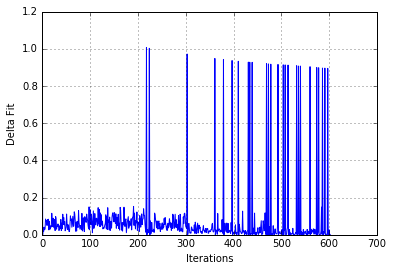

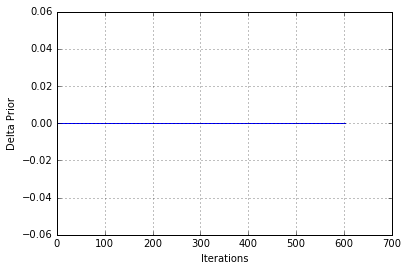

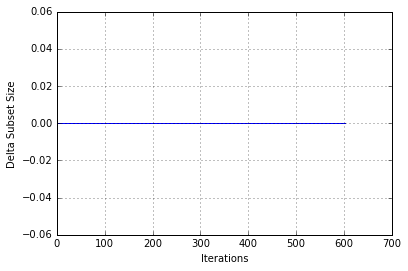

In [191]:
d1,d2,d3 = zip(*model.deltaLog)
plt.plot(range(len(d1)),d1)
plt.grid()
plt.ylabel("Delta Fit")
plt.xlabel("Iterations")
plt.show()
plt.plot(range(len(d1)),d2)
plt.grid()
plt.ylabel("Delta Prior")
plt.xlabel("Iterations")
plt.show()
plt.plot(range(len(d1)),d3)
plt.grid()
plt.ylabel("Delta Subset Size")
plt.xlabel("Iterations")
plt.show()
          

In [14]:
#Prototypes selection for multiples prototype numbers

from scipy import stats
z_critical = stats.norm.ppf(q = 0.975)

nrandomsamples = 10
nprototypesList = [50,100,200,500,1000,5000,10000]

greedyPerfFscore = []
greedyPerfAccuracy = []
randomPerfSamples = []

for nprototypes in nprototypesList:
    optimgraph = model.train(nprototypes,6,0)
    print model.prototypeSize
    joblib.dump(model,str(nprototypes)+'PrototypeSelectionModel_Trained.pkl')
    
    testPred = model.predict(test_x)
    greedyPerfFscore.append(evalMetrics.classification.f1_score(test_set[1],testPred,average='macro'))
    greedyPerfAccuracy.append(evalMetrics.accuracy_score(test_set[1],testPred))

    randomPerfSamples.append(randomPrototypePerformance(nprototypes,nrandomsamples))
    

Mean_accuracy,Std_accuracy,Mean_microf,Std_microf = zip(*randomPerfSamples)


Finding Prototypes
90.0% complete
Forming the search tree
Training done
50.0
Finding Prototypes
100.0% complete
Forming the search tree
Training done
100.0
Finding Prototypes
100.0% complete
Forming the search tree
Training done
200.0
Finding Prototypes
100.0% complete
Forming the search tree
Training done
500.0
Finding Prototypes
100.0% complete
Forming the search tree
Training done
1000.0
Finding Prototypes
99.94% complete
Forming the search tree
Training done
5000.0
Finding Prototypes
50.65% complete
Forming the search tree
Training done
5070.0


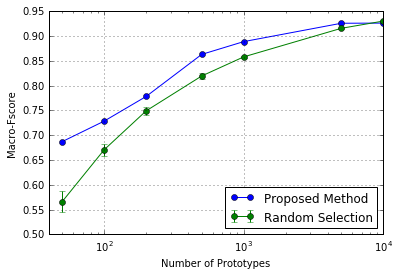

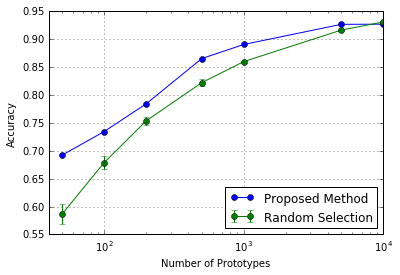

In [21]:
from scipy import stats
import matplotlib.pyplot as plt

z_critical = stats.norm.ppf(q = 0.975)

greedyPerfFscore = []
greedyPerfAccuracy = []
randomPerfSamples = []

for nprototypes in nprototypesList:
    model = joblib.load(str(nprototypes)+'PrototypeSelectionModel_Trained.pkl')
    
    testPred = model.predict(test_x)
    greedyPerfFscore.append(evalMetrics.classification.f1_score(test_set[1],testPred,average='macro'))
    greedyPerfAccuracy.append(evalMetrics.accuracy_score(test_set[1],testPred))

    randomPerfSamples.append(randomPrototypePerformance(nprototypes,nrandomsamples))
    

Mean_accuracy,Std_accuracy,Mean_microf,Std_microf = zip(*randomPerfSamples)

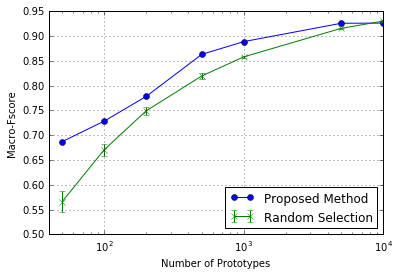

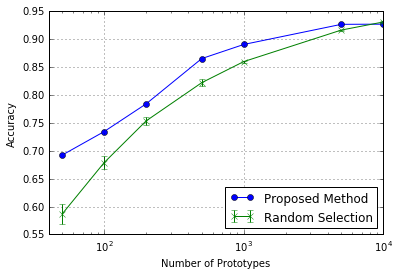

In [27]:
#Plot results

SerrMargin = z_critical*np.array(Std_microf)/math.sqrt(nrandomsamples)
plt.plot(nprototypesList,greedyPerfFscore,marker = 'o',label = 'Proposed Method')
plt.errorbar(nprototypesList,Mean_microf,SerrMargin,marker = 'x',label = 'Random Selection')
plt.xlim(min(nprototypesList)-10,max(nprototypesList)+10)
#plt.title(" Comparison")
plt.xscale('log')
plt.xlabel('Number of Prototypes')
plt.ylabel('Macro-Fscore')
plt.grid()
plt.legend(loc = 4)
#plt.savefig('FscoreComparison.pdf')
plt.show()

SerrMargin = z_critical*np.array(Std_accuracy)/math.sqrt(nrandomsamples)
plt.plot(nprototypesList,greedyPerfAccuracy,marker = 'o',label = 'Proposed Method')
plt.errorbar(nprototypesList,Mean_accuracy,SerrMargin,marker = 'x',label = 'Random Selection')
plt.xlim(min(nprototypesList)-10,max(nprototypesList)+10)
#plt.title("Accuracy Comparison")
plt.xscale('log')
plt.xlabel('Number of Prototypes')
plt.ylabel("Accuracy")
plt.grid()
plt.legend(loc=4)
#plt.savefig('AccuracyComparison.pdf')
plt.show()

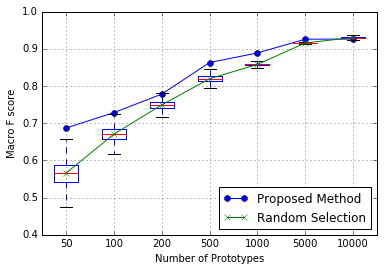

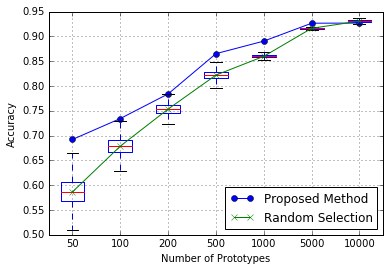

In [108]:
def getBData(mean,variance):
    errors = []
    labels = [50,100,200,500,1000,5000,10000]
    for i in range(len(mean)):
        simErrors = np.random.normal(mean[i],variance[i],5000)
        errors.append(simErrors)
    return (errors,labels)

simFscore,Labels = getBData(Mean_microf,Std_microf)

plt.figure()
plt.plot(range(1,8),greedyPerfFscore,marker = 'o',label = 'Proposed Method')
bp = plt.boxplot(simFscore,labels = nprototypesList,showfliers = False)
plt.plot(range(1,8),Mean_microf,marker = 'x',label = 'Random Selection')
#plt.xscale('log')
plt.xlabel('Number of Prototypes')
plt.ylabel("Macro F score")
plt.grid()
plt.legend(loc=4)
plt.savefig("FscoreBoxplot.pdf")
plt.show()

simAccuracy,Labels = getBData(Mean_accuracy,Std_accuracy)

plt.figure()
plt.plot(range(1,8),greedyPerfAccuracy,marker = 'o',label = 'Proposed Method')
bp = plt.boxplot(simAccuracy,labels = nprototypesList,showfliers = False)
plt.plot(range(1,8),Mean_accuracy,marker = 'x',label = 'Random Selection')
#plt.xscale('log')
plt.xlabel('Number of Prototypes')
plt.ylabel("Accuracy")
plt.grid()
plt.legend(loc=4)
plt.savefig("AccuracyBoxplot.pdf")
plt.show()

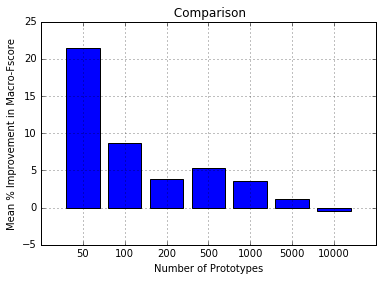

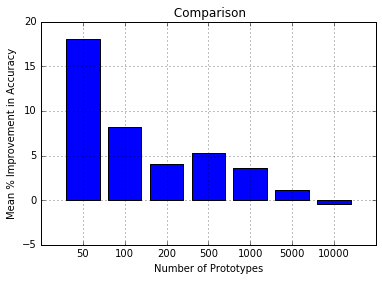

In [144]:
#def computePercentError(x,y):
#   return 100*(np.array(x)-np.array(y))/np.array(y)

#def getBootstrapData(realSolution,mean,variance):
#    errors = []
#    labels = []
#    for i in range(len(realSolution)):
#        simSolution = np.random.normal(mean[i],variance[i],50000)
#        simErrors = computePercentError([realSolution[i]]*50000,simSolution)
#        errors.append(simErrors)
#    return (errors,labels)

#data,labels = getBootstrapData(greedyPerfAccuracy,Mean_accuracy,Std_accuracy)
#print len(data)
#plt.figure()
#plt.boxplot(data,labels = [50,100,200,500,1000,5000,10000],showfliers=False)
#plt.xticks([50,100,200,500,1000,5000,10000])
#plt.show()
stringnames = [str(x) for x in nprototypesList]
#plt.plot(nprototypesList,100*(np.array(greedyPerfFscore)-np.array(Mean_microf))/np.array(Mean_microf),marker = 'o')
plt.bar(range(0,7),100*(np.array(greedyPerfFscore)-np.array(Mean_microf))/np.array(Mean_microf),align = 'center')
plt.xticks(range(0,7,1),stringnames)
plt.title(" Comparison")

plt.xlabel('Number of Prototypes')
plt.ylabel('Mean % Improvement in Macro-Fscore')
plt.grid()
plt.legend(loc = 4)
plt.savefig('FscoreImprovement.pdf')
plt.show()

stringnames = [str(x) for x in nprototypesList]
#plt.plot(nprototypesList,100*(np.array(greedyPerfFscore)-np.array(Mean_microf))/np.array(Mean_microf),marker = 'o')
plt.bar(range(0,7),100*(np.array(greedyPerfAccuracy)-np.array(Mean_accuracy))/np.array(Mean_accuracy),align = 'center')
plt.xticks(range(0,7,1),stringnames)
plt.title(" Comparison")

plt.xlabel('Number of Prototypes')
plt.ylabel('Mean % Improvement in Accuracy')
plt.grid()
plt.legend(loc = 4)
plt.savefig('AccuracyImprovement.pdf')
plt.show()
#cf = []

#errors = [computePercentError(lower,Mean_accuracy),computePercentError(upper,Mean_accuracy)]
#plt.plot(nprototypesList,computePercentError(greedyPerfAccuracy,Mean_accuracy),marker = 'o')
#plt.errorbar(nprototypesList,Mean_microf,SerrMargin,marker = 'o',label = 'Random Selection')
#plt.xlim(min(nprototypesList)-10,max(nprototypesList)+10)
#plt.title(" Comparison")
#plt.xscale('log')
#plt.xlabel('Number of Prototypes')
#plt.ylabel('% Improvement in Accuracy')
#plt.grid()
#plt.legend(loc = 4)
#plt.savefig('AccuracyImprovement.pdf')
#plt.show()

In [149]:
x = {1:2,3:4}
print x
print x.values()

{1: 2, 3: 4}
[2, 4]
